In [1]:
import pandas as pd 
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
#from tabulate import tabulate
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report
#from sklearn.model_selection import GridSearchCV
import shap


In [2]:
# Load train & test data
test_df = pd.read_csv('../Data/test_df0.1.csv')
train_df = pd.read_csv('../Data/train_df0.1.csv')

In [3]:
# HadHeartAttack as response
x_train = train_df[train_df.columns.difference(["HadHeartAttack"])]
x_test = test_df[train_df.columns.difference(["HadHeartAttack"])]
y_train = train_df.HadHeartAttack
y_test = test_df.HadHeartAttack

In [5]:
# Training & testing scores of XGBoost based on different learning rates
learning_rate_range = np.arange(0.01, 1, 0.05)
test_XG = [] 
train_XG = []
for lr in learning_rate_range:
    xgb_model = xgb.XGBClassifier(eta = lr, nthread=4)
    xgb_model.fit(x_train, y_train)
    train_XG.append(xgb_model.score(x_train, y_train))
    test_XG.append(xgb_model.score(x_test, y_test))

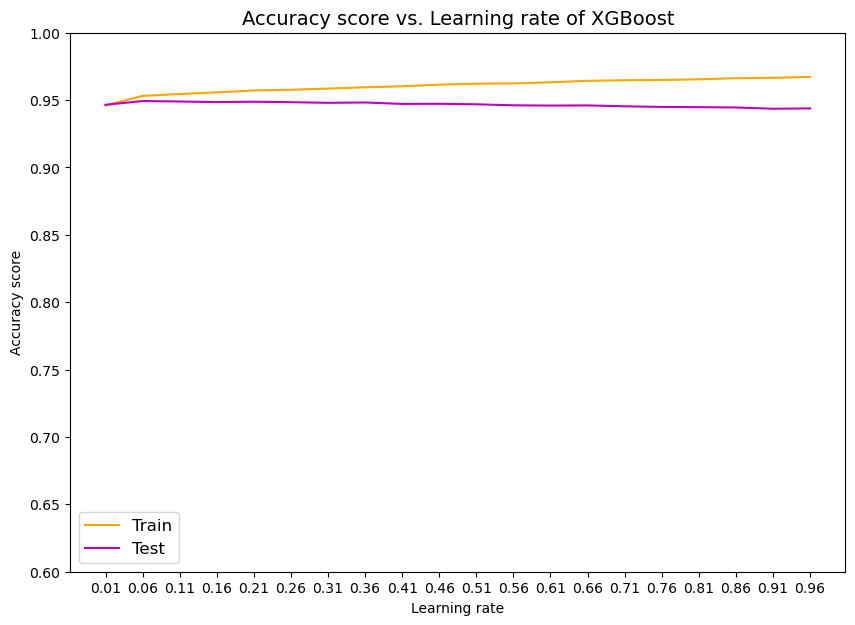

In [6]:
# Plot out accuracy scores
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

In [12]:
# Not so much problem with overfitting, since similar performance between training & test data suggests
# that there's not so much irrelevant detail from the training data that the model is learning that affects
# the performance on test data

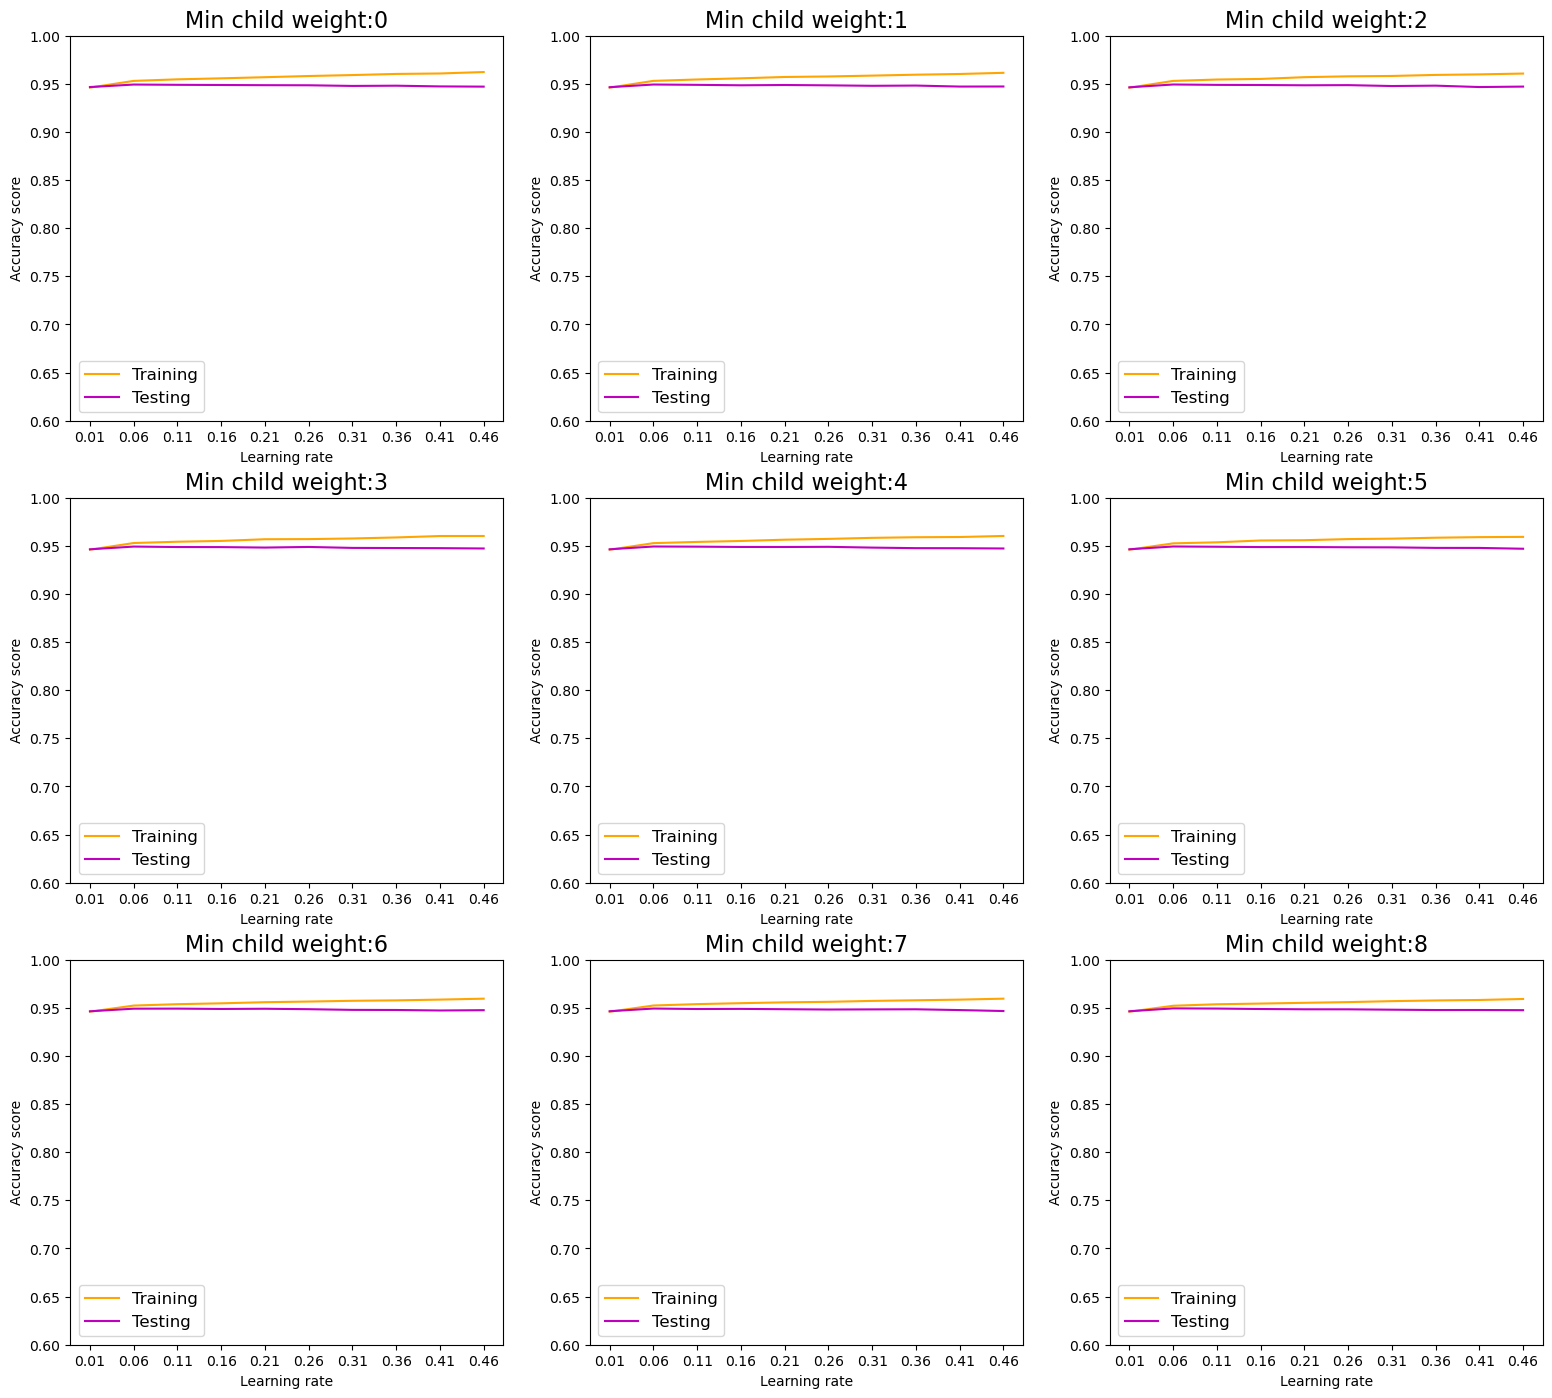

In [7]:
# new learning rate range
learning_rate_range = np.arange(0.01, 0.5, 0.05)
fig = plt.figure(figsize=(19, 17))
idx = 1
# grid search for min_child_weight
for weight in np.arange(0, 9, 1):
    train = []
    test = []
    for lr in learning_rate_range:
        xgb_model = xgb.XGBClassifier(eta = lr,reg_lambda=1, min_child_weight=weight, nthread=4)
        xgb_model.fit(x_train, y_train)
        train.append(xgb_model.score(x_train, y_train))
        test.append(xgb_model.score(x_test, y_test))
    fig.add_subplot(3, 3, idx)
    idx += 1
    plt.plot(learning_rate_range, train, c='orange', label='Training')
    plt.plot(learning_rate_range, test, c='m', label='Testing')
    plt.xlabel('Learning rate')
    plt.xticks(learning_rate_range)
    plt.ylabel('Accuracy score')
    plt.ylim(0.6, 1)
    plt.legend(prop={'size': 12}, loc=3)
    title = "Min child weight:" + str(weight)
    plt.title(title, size=16)
plt.show()

In [9]:
# Create model with new parameters based on results
xgb_model = xgb.XGBClassifier(eta = 0.06, nthread=4, min_child_weight=8)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=8, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, nthread=4, ...)

In [10]:
# Try making predictions
predictions = xgb_model.predict(x_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, predictions))


Accuracy: 0.9494356903816711

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     69825
           1       0.58      0.23      0.33      3982

    accuracy                           0.95     73807
   macro avg       0.77      0.61      0.65     73807
weighted avg       0.94      0.95      0.94     73807



In [11]:
shap.initjs()

In [12]:
# Use a random sample of the dataset for faster calculation
X_sampled = x_train.sample(100, random_state=25)

# Explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sampled)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

[15:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [13]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_sampled)

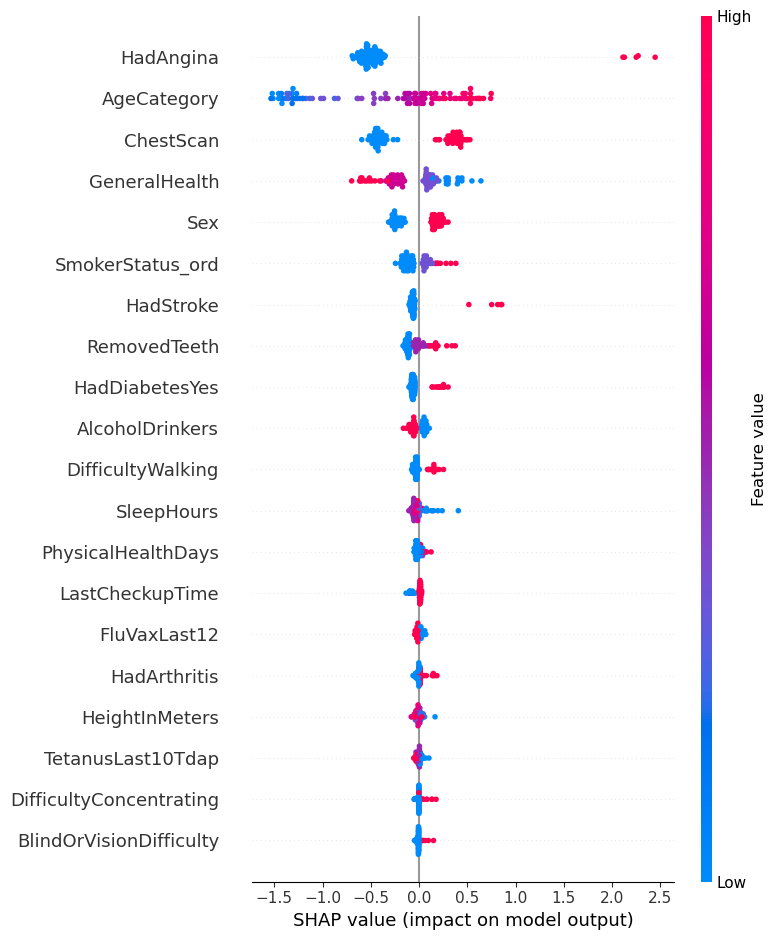

In [14]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

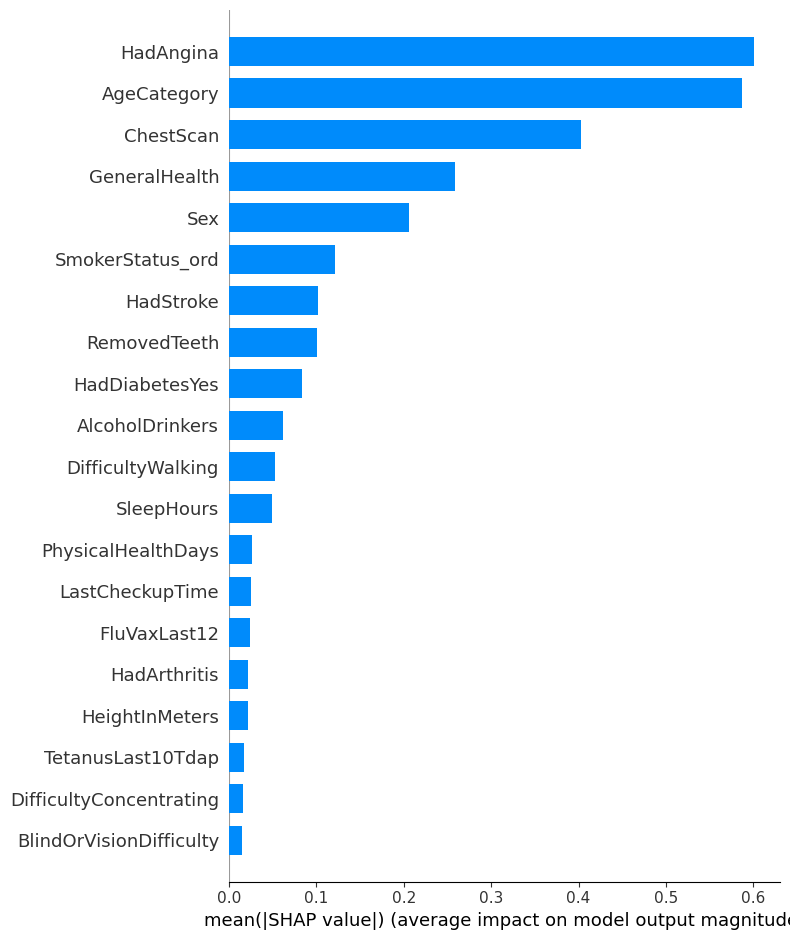

In [15]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

##### Reference:
- https://medium.com/@24littledino/xgboost-classification-in-python-f29cc2c50a9b
- https://www.educative.io/answers/classification-using-xgboost-in-python
- https://www.kaggle.com/code/bryanb/xgboost-explainability-with-shap#-5.-SHapley-Additive-exPlanations
- https://xgboost.readthedocs.io/en/stable/parameter.html
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/